## Setting

In [110]:
#from google.colab import drive
#drive.mount('/content/drive',force_remount=True)
import torch
import torch.nn as nn
import numpy as np
import sys
#sys.path.append("/content/drive/My Drive/LCNN/")

import os
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt



import imp
import importlib
#device = torch.device('cuda')
device = torch.device('cpu')




import copy
from IPython.display import HTML, display
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))




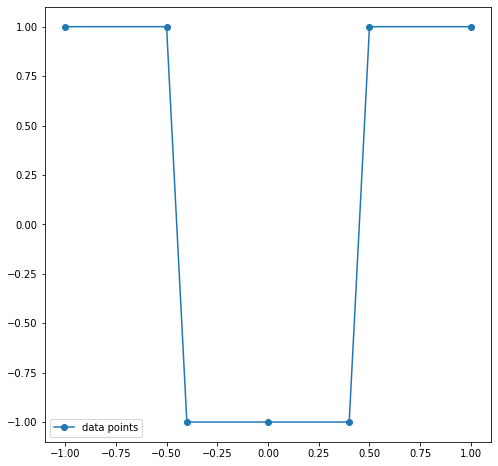

In [111]:
Nmin=-1
Nmax=1
datanumber=7
class MyDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = {'data': float(self.data[idx]), 'label': self.label[idx]}
        return sample

    
def fun(x):
    return np.sin(x*np.pi)


data=np.array([-1,-0.5,-0.4,0,0.4,0.5,1])*1.0
label=-(np.array([0,0,1,1,1,0,0])*2.0-1)

train_data=data
train_label=label

plt.plot(train_data,train_label,'-o',label='data points')
plt.legend()
plt.savefig('data_points.png')

train_loader = torch.utils.data.DataLoader(dataset=MyDataset(train_data,train_label), 
                                           batch_size=datanumber, 
                                           shuffle=False)

device = torch.device('cuda')

In [119]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 1


num_classes = 1

NNN=50

class NeuralNet2layer(nn.Module):
    def __init__(self, input_size, hidden_size1,num_classes):
        super(NeuralNet2layer, self).__init__()
        self.input_size = input_size
        self.hidden_size1 = hidden_size1


        self.fc1 = nn.Linear(input_size, hidden_size1) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias=False)
        stdv = 1. / np.sqrt(self.hidden_size1)
        print(self.hidden_size1)

        #self.fc1.weight.detach().uniform_(-1, 1)
        #self.fc1.bias.detach().uniform_(-1, 1)
        #self.fc2.weight.detach().uniform_(-1/np.sqrt(NNN), 1/np.sqrt(NNN))



        self.fc1.weight.detach().normal_(0, 1)
        self.fc1.bias.detach().normal_(0, 1)
        self.fc2.weight.detach().normal_(0, 1/np.sqrt(NNN))


    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [113]:
def plot_training(model,node_num=1000):
    plt.plot(train_data,train_label,'x',label=r'$x_j,y_j$')

    
    x= np.linspace(Nmin, Nmax, num=node_num)
    y= np.zeros(node_num)
    with torch.no_grad():
        for i in range(node_num):
            xx=torch.tensor(x[i]).reshape(-1, 1).to(device).float()
            y[i]=model(xx).to(device).cpu().numpy()
    plt.plot(x,y,'-',label=r'$x,f(x)$')
 


def get_line(model,node_num=1000,Nmin=-1, Nmax=1):
    x= np.linspace(Nmin, Nmax, num=node_num)
    y= np.zeros(node_num)
    with torch.no_grad():
        for i in range(node_num):
            xx=torch.tensor(x[i]).reshape(-1, 1).to(device).float()
            y[i]=model(xx).to(device).cpu().numpy()
    return x,y


def modify_init(record_i=1,hidden_size1=20,learning_rate=0.2,epoch=10000,dev=100,gamma=1):
    # hidden_size1=hidden_size1
    # dev=dev
    # learning_rate=learning_rate
    # beta=beta



    torch.manual_seed(144)
    line=[]
    abc=[]
    device = torch.device('cuda')
    model = NeuralNet2layer(1, hidden_size1,1).to(device)
    traj=[]
    with torch.no_grad():
        model.fc1.weight[record_i][0]=0.5
        model.fc1.bias[record_i]=-0.1
        model.fc2.weight[0][record_i]=0.1/np.sqrt(NNN)
        model.fc1.weight[:]=gamma*model.fc1.weight[:]
        model.fc1.bias[:]=gamma*model.fc1.bias[:]
        model.fc2.weight[:]=gamma*model.fc2.weight[:]

    


    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
    outdis = display(progress(0, 100), display_id=True)
    criterion = nn.MSELoss()

    for i, data in enumerate(train_loader):
        pass
    images = data['data'].reshape(-1, 1).to(device).float()
    labels = data['label'].reshape(-1, 1).to(device).float()
    
    lo=10
    for runsteps in range(epoch):
        if runsteps==10000 or runsteps==20000 or runsteps==30000:
            learning_rate = learning_rate * 10
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
            
        if runsteps% dev==0 or lo<0.001:
            outdis.update(progress(outdis.update(progress(100.*runsteps/epoch, 100)), 100))
            

            x=-model.fc1.bias[record_i]/model.fc1.weight[record_i][0].reshape(-1, 1).to(device).float()
            traj.append([x,model(x)])

            a=model.fc1.weight[record_i][0].cpu().detach().numpy()
            b=model.fc1.bias[record_i].cpu().detach().numpy()
            c=model.fc2.weight[0][record_i].cpu().detach().numpy()

            abc.append([a,b,c])
            print(runsteps,lo)
        if lo<0.001:
            x,y=get_line(model,node_num=10000)
            line=[x,y]
            print('converged')
            break
    
        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lo=loss.item()
    return line,abc,traj

## init

50


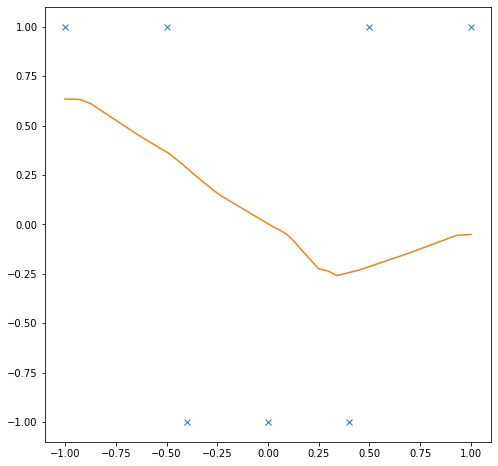

In [114]:
    torch.manual_seed(0)
    batchnorm=False
    device = torch.device('cuda')
    model = NeuralNet2layer(input_size, NNN,num_classes).to(device)
    plot_training(model)

## N variation 

In [115]:
linelist=[]
abclist=[]
trajlist=[]
N=[50,500,5000,50000]
for n in N:
    gamma=(NNN/n)**(1/4)
    line,abc,traj=modify_init(hidden_size1=n,learning_rate=0.0005,epoch=50000,dev=200,gamma=gamma)
    linelist.append(line)
    abclist.append(abc)
    trajlist.append(traj)


50


0 10
200 0.5449091196060181
400 0.48636606335639954
600 0.47126105427742004
800 0.46462348103523254
1000 0.46003273129463196
1200 0.45606857538223267
1400 0.4524429142475128
1600 0.4490741193294525
1800 0.44589078426361084
2000 0.44285067915916443
2200 0.43996840715408325
2400 0.43745702505111694
2600 0.43500760197639465
2800 0.4326018691062927
3000 0.4302765727043152
3200 0.4279903769493103
3400 0.4257272183895111
3600 0.42349472641944885
3800 0.4212762415409088
4000 0.4190877676010132
4200 0.41689854860305786
4400 0.41471460461616516
4600 0.41251033544540405
4800 0.41030699014663696
5000 0.4080792963504791
5200 0.4058491289615631
5400 0.40364739298820496
5600 0.4014297127723694
5800 0.3991749882698059
6000 0.3969068229198456
6200 0.3946011960506439
6400 0.3922668993473053
6600 0.3898903429508209
6800 0.3874656558036804
7000 0.3850122392177582
7200 0.3825058341026306
7400 0.37996551394462585
7600 0.37736254930496216
7800 0.3747365176677704
8000 0.37203046679496765
8200 0.3693009316921

0 10
200 0.45923545956611633
400 0.4420278072357178
600 0.4271641969680786
800 0.4148571193218231
1000 0.40422385931015015
1200 0.39455243945121765
1400 0.3858829438686371
1600 0.37774649262428284
1800 0.3699806034564972
2000 0.362498939037323
2200 0.35520175099372864
2400 0.3480406403541565
2600 0.3410612642765045
2800 0.3342244029045105
3000 0.32747316360473633
3200 0.32072919607162476
3400 0.3139834403991699
3600 0.3072444200515747
3800 0.30049338936805725
4000 0.29374486207962036
4200 0.28700798749923706
4400 0.2802734076976776
4600 0.27360883355140686
4800 0.26701223850250244
5000 0.2604938745498657
5200 0.2540321350097656
5400 0.24759773910045624
5600 0.24118800461292267
5800 0.234940305352211
6000 0.2288563996553421
6200 0.22282016277313232
6400 0.2168465107679367
6600 0.21091268956661224
6800 0.20506682991981506
7000 0.19928720593452454
7200 0.19360962510108948
7400 0.18799655139446259
7600 0.18245051801204681
7800 0.17698007822036743
8000 0.17158375680446625
8200 0.16628944873

0 10
200 0.4169292151927948
400 0.3779153525829315
600 0.3522980809211731
800 0.33173561096191406
1000 0.3134533166885376
1200 0.29681921005249023
1400 0.28131014108657837
1600 0.2665794789791107
1800 0.252490371465683
2000 0.23896783590316772
2200 0.22596529126167297
2400 0.21343545615673065
2600 0.20139260590076447
2800 0.1899084597826004
3000 0.17899006605148315
3200 0.16856378316879272
3400 0.15861515700817108
3600 0.14911046624183655
3800 0.14003367722034454
4000 0.13138841092586517
4200 0.12318743020296097
4400 0.11541280150413513
4600 0.10804304480552673
4800 0.10106296092271805
5000 0.09446410089731216
5200 0.08822517096996307
5400 0.08233294636011124
5600 0.07677267491817474
5800 0.0715467631816864
6000 0.06663461774587631
6200 0.06202666461467743
6400 0.05770882964134216
6600 0.053658049553632736
6800 0.0498652383685112
7000 0.04630756005644798
7200 0.04297622665762901
7400 0.03986692428588867
7600 0.03696812689304352
7800 0.034256380051374435
8000 0.03172905743122101
8200 0.

0 10
200 0.32073256373405457
400 0.25519055128097534
600 0.21085797250270844
800 0.1765575259923935
1000 0.14861935377120972
1200 0.1252480447292328
1400 0.10560747236013412
1600 0.08900962769985199
1800 0.0750209391117096
2000 0.06319108605384827
2200 0.05318011716008186
2400 0.04473578557372093
2600 0.03760566934943199
2800 0.031593818217515945
3000 0.02652967907488346
3200 0.022262191399931908
3400 0.018670164048671722
3600 0.01564730517566204
3800 0.013106347061693668
4000 0.010972614400088787
4200 0.009182214736938477
4400 0.0076804687269032
4600 0.00642138859257102
4800 0.005366789177060127
5000 0.004483920522034168
5200 0.0037455002311617136
5400 0.0031281637493520975
5600 0.0026118524838238955
5800 0.0021802023984491825
6000 0.0018194617005065084
6200 0.0015180391492322087
6400 0.001266279723495245
6600 0.0010560753289610147
6661 0.0009991673287004232
converged


Text(0.5, 1.0, 'N=5000,$\\gamma=(N/M)^{1/4}$,noscale,[-1,1]]')

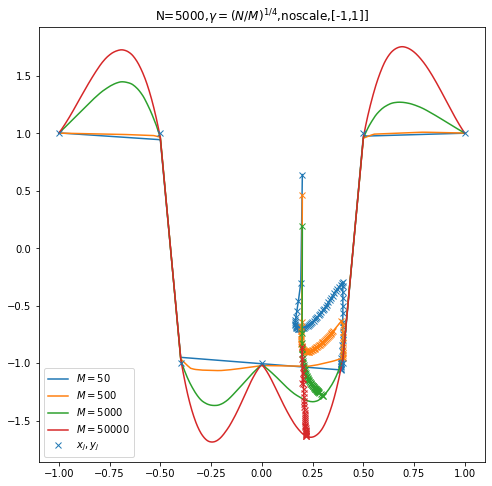

In [118]:
plt.rcParams["figure.figsize"] = (8,8)
c=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
for i in range(len(N)):
    plt.plot(linelist[i][0],linelist[i][1],label=r'$M=$'+str(N[i]),color=c[i])
    traj=torch.tensor(trajlist[i]).cpu()
    plt.plot(traj[:,0],traj[:,1],'x-',color=c[i])
plt.plot(train_data,train_label,'x',label=r'$x_j,y_j$')

plt.legend()
plt.title(r'N=5000,$\gamma=(N/M)^{1/4}$,noscale,[-1,1]]')
#plt.savefig('/content/drive/My Drive/LCNN/newplots/1over4.pdf')